In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SequentialFeatureSelector
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

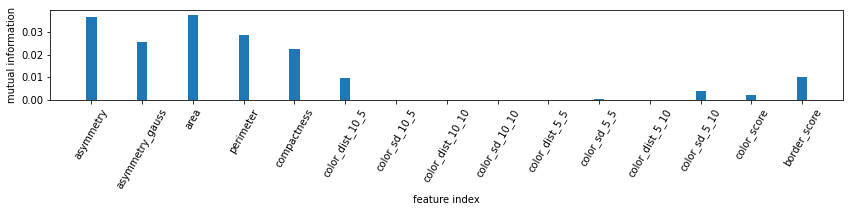

In [100]:
df = pd.read_csv("features/features_training.csv")
X = df.drop(["image_id", "melanoma"], axis=1)
y = df["melanoma"]
feature_names = list(df)[2:]
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X, y)

# Show the feature scores
scores = selector.scores_


fig, ax = plt.subplots(figsize=(12,3))
ax.bar(feature_names, scores, width=.2)
ax.set_xlabel('feature index')
ax.set_ylabel('mutual information')
plt.xticks(rotation=60);
plt.tight_layout()
plt.savefig("figures/mutual_info.png", bbox_inches="tight", dpi=400)

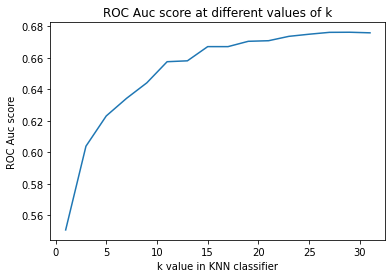

In [68]:
df = pd.read_csv("features/features_training.csv")
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

k_auc_scores = np.empty((16))

for j, k in enumerate(range(1, 32, 2)):
    acc_val_knn = np.empty((n_splits, 1))
    auc_val_knn = np.empty((n_splits, 1))
    acc_val_tree = np.empty((n_splits, 1))
    auc_val_tree = np.empty((n_splits, 1))

    threshold = 0.2

    for i, (train_index, val_index) in enumerate(kf.split(x, y)):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = KNeighborsClassifier(n_neighbors=k)
        clf = clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]
        
        acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
        auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

        clf = DecisionTreeClassifier(random_state=1)
        clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]

        acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
        auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
        

    k_auc_scores[j] = np.mean(auc_val_knn)
ax = sns.lineplot(x=range(1, 32, 2), y=k_auc_scores)
ax.set_ylabel("ROC Auc score")
ax.set_xlabel("k value in KNN classifier")
ax.set_title("ROC Auc score at different values of k");

KNN Accuracy scores
acc_score: 0.806 ±0.01
auc_score: 0.644 ±0.01
______________________________
Decision Tree Accuracy scores
acc_score: 0.724 ±0.01
auc_score: 0.547 ±0.01

Confusion matrix for threshold 0.2
[[0.58646154 0.41353846]
 [0.38133333 0.61866667]]


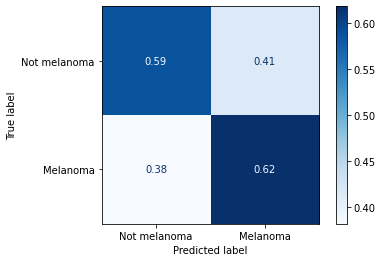

In [102]:
df = pd.read_csv("features/features_training.csv")
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_val_knn = np.empty((n_splits, 1))
auc_val_knn = np.empty((n_splits, 1))
acc_val_tree = np.empty((n_splits, 1))
auc_val_tree = np.empty((n_splits, 1))

k = 9 
threshold = 0.2


conf_mats = []

for i, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]
    
    acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
    auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

    conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]

    acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
    auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
    

    

print("KNN Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_knn):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_knn):.2f}")
print("_"*30)
print("Decision Tree Accuracy scores")
print(f"acc_score: {np.mean(acc_val_tree):.3f} ±{np.std(acc_val_tree):.2f}")
print(f"auc_score: {np.mean(auc_val_tree):.3f} ±{np.std(auc_val_tree):.2f}")

print(f"\nConfusion matrix for threshold {threshold}")
conf_mats = np.stack(conf_mats, axis=2)
avg_conf_mat = np.mean(conf_mats, axis=2)
avg_conf_mat = normalize(avg_conf_mat, norm="l1")
print(avg_conf_mat)
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
display.plot(cmap=plt.cm.Blues);

Selected features for JSON Features:  [4 3 0 7 5]
KNN Accuracy scores
acc_score: 0.817 ±0.00
auc_score: 0.686 ±0.02
______________________________
Decision Tree Accuracy scores
acc_score: 0.733 ±0.01
auc_score: 0.572 ±0.01

Confusion matrix for threshold 0.2
[[0.65446154 0.34553846]
 [0.372      0.628     ]]


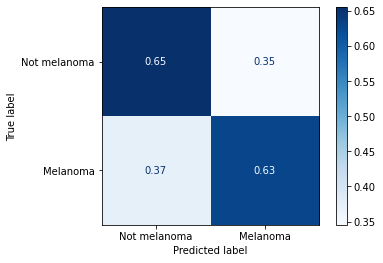

In [103]:
df = pd.read_csv("features/features_training.csv")
#features = ["asymmetry", "area", "perimeter", "compactness", "color_dist_10_5", "color_score"]
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

# JSON Data
def to_numpy(arr):
    return np.array(arr[1:-1].split(), dtype=int)

converters = {'pigment_network_hist': to_numpy, 'negative_network_hist': to_numpy, 'milia_like_hist': to_numpy, 'streaks_hist': to_numpy}
jdf = pd.read_csv("features/json_training.csv", converters=converters)
features = list(jdf.drop(columns=["image_id", "melanoma"]))
xj = np.hstack([np.vstack(jdf[feat].to_numpy()) for feat in features])
selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(xj, y)
scores = selector.scores_
selected_indices = np.argsort(selector.scores_)[-5:]
print("Selected features for JSON Features: ", selected_indices)
xj = xj[:, selected_indices]
x = np.c_[x, xj]


x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

acc_val_knn = np.empty((n_splits, 1))
auc_val_knn = np.empty((n_splits, 1))
acc_val_tree = np.empty((n_splits, 1))
auc_val_tree = np.empty((n_splits, 1))

k = 9
threshold = 0.2


conf_mats = []

for i, (train_index, val_index) in enumerate(kf.split(x, y)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]
    
    acc_val_knn[i] = accuracy_score(y_val, y_pred_val)
    auc_val_knn[i] = roc_auc_score(y_val, y_prob_val)

    conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(x_train, y_train)
    y_pred_val = clf.predict(x_val)
    y_prob_val = clf.predict_proba(x_val)[:,1]

    acc_val_tree[i] = accuracy_score(y_val, y_pred_val)
    auc_val_tree[i] = roc_auc_score(y_val, y_prob_val)
    

    

print("KNN Accuracy scores")
print(f"acc_score: {np.mean(acc_val_knn):.3f} ±{np.std(acc_val_knn):.2f}")
print(f"auc_score: {np.mean(auc_val_knn):.3f} ±{np.std(auc_val_knn):.2f}")
print("_"*30)
print("Decision Tree Accuracy scores")
print(f"acc_score: {np.mean(acc_val_tree):.3f} ±{np.std(acc_val_tree):.2f}")
print(f"auc_score: {np.mean(auc_val_tree):.3f} ±{np.std(auc_val_tree):.2f}")

print(f"\nConfusion matrix for threshold {threshold}")
conf_mats = np.stack(conf_mats, axis=2)
avg_conf_mat = np.mean(conf_mats, axis=2)
avg_conf_mat = normalize(avg_conf_mat, norm="l1")
print(avg_conf_mat)
display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
display.plot(cmap=plt.cm.Blues);

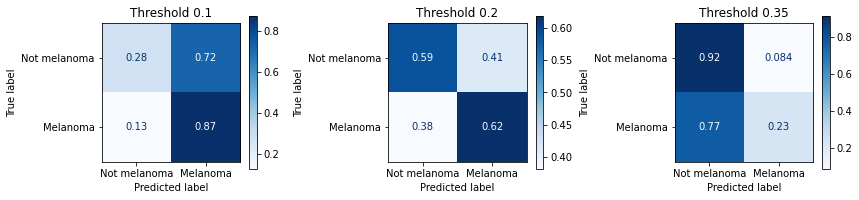

In [101]:
df = pd.read_csv("features/features_training.csv")
features = ["asymmetry", "area", "perimeter", "color_dist_10_5", "color_score"]

x = df[features].to_numpy()
y = np.array(df["melanoma"])

x = MinMaxScaler().fit_transform(x)

n_splits = 5
kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=1)

k = 9 

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for threshold, ax in zip([0.1, 0.2, 0.35], axes.flatten()):
    conf_mats = []
    for i, (train_index, val_index) in enumerate(kf.split(x, y)):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = KNeighborsClassifier(n_neighbors=k)
        clf = clf.fit(x_train, y_train)
        y_pred_val = clf.predict(x_val)
        y_prob_val = clf.predict_proba(x_val)[:,1]

        conf_mats.append(confusion_matrix(y_val, y_prob_val > threshold))

    conf_mats = np.stack(conf_mats, axis=2)
    avg_conf_mat = np.mean(conf_mats, axis=2)
    avg_conf_mat = normalize(avg_conf_mat, norm="l1")
    display = ConfusionMatrixDisplay(avg_conf_mat, display_labels=["Not melanoma", "Melanoma"])
    display.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f"Threshold {threshold}")
plt.tight_layout()
plt.savefig("figures/conf_mats.png", bbox_inches="tight", dpi=400)

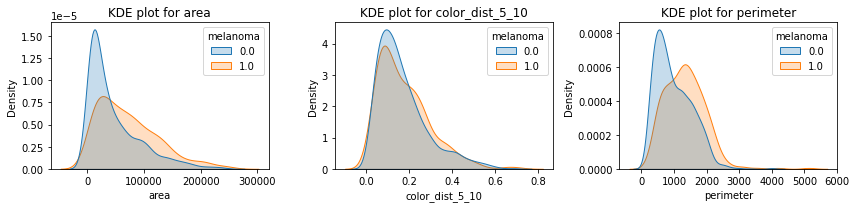

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
features = ['area', 'color_dist_5_10', 'perimeter']
for feature, ax in zip(features, axes.flatten()):
    sns.kdeplot(feature, data=df, hue="melanoma", fill=True, common_norm=False, ax=ax)
    ax.set_title(f"KDE plot for {feature}")
plt.tight_layout()
plt.savefig("figures/kde_plots.png", bbox_inches="tight", dpi=400)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6840a14b-d41a-45b9-abd0-892354334cb2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>